In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, SVHN
import torch.utils.data as data_util
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)
device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
elec = pd.read_csv('elec_merge.csv')
nelec = pd.read_csv('n_elec_merge.csv')

In [4]:
scaler_nelec = MinMaxScaler()
scaler_elec = MinMaxScaler()

scaler_nelec.fit(nelec)
scaler_elec.fit(elec)

scaled_nelec = scaler_nelec.transform(nelec)
scaled_elec = scaler_elec.transform(elec)

new_nelec = pd.DataFrame(scaled_nelec, index=nelec.index, columns=nelec.columns)
new_elec = pd.DataFrame(scaled_elec, index=elec.index, columns=elec.columns)

In [5]:
input_nelec = new_nelec.iloc[:-1,].reset_index(drop=True)
output_nelec = new_nelec[['n_elec']].iloc[1:].reset_index(drop=True)
output_nelec.columns = ['nelec']

input_elec = new_elec.iloc[:-1,].reset_index(drop=True)
output_elec = new_elec[['ELEC']].iloc[1:].reset_index(drop=True)
output_elec.columns = ['elec']

nelec = pd.concat([input_nelec, output_nelec], axis=1)
elec = pd.concat([input_elec, output_elec], axis=1)

In [6]:
standard_nelec = int(len(nelec) * 0.7)
standard_elec = int(len(elec) * 0.7)

nelec_train = nelec.iloc[:standard_nelec]
nelec_test = nelec.iloc[standard_nelec:].reset_index(drop=True)

elec_train = elec.iloc[:standard_elec]
elec_test = elec.iloc[standard_elec:].reset_index(drop=True)

In [7]:
nelec_trainx = nelec_train.drop(['nelec'], axis=1)
nelec_trainy = nelec_train[['nelec']]

nelec_testx = nelec_test.drop(['nelec'], axis=1)
nelec_testy = nelec_test[['nelec']]

elec_trainx = elec_train.drop(['elec'], axis=1)
elec_trainy = elec_train[['elec']]

elec_testx = elec_test.drop(['elec'], axis=1)
elec_testy = elec_test[['elec']]

In [8]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

nelec_trainx, nelec_trainy = buildDataSet(nelec_trainx, nelec_trainy, 3)
nelec_testx, nelec_testy = buildDataSet(nelec_testx, nelec_testy, 3)

elec_trainx, elec_trainy = buildDataSet(elec_trainx, elec_trainy, 3)
elec_testx, elec_testy = buildDataSet(elec_testx, elec_testy, 3)

In [9]:
# 텐서로 변환
nelec_trainx_tensor = torch.FloatTensor(nelec_trainx)
nelec_trainy_tensor = torch.FloatTensor(nelec_trainy)

nelec_testx_tensor = torch.FloatTensor(nelec_testx)
nelec_testy_tensor = torch.FloatTensor(nelec_testy)

elec_trainx_tensor = torch.FloatTensor(elec_trainx)
elec_trainy_tensor = torch.FloatTensor(elec_trainy)

elec_testx_tensor = torch.FloatTensor(elec_testx)
elec_testy_tensor = torch.FloatTensor(elec_testy)

In [10]:
# 텐서 형태로 데이터 정의
nelec_train = TensorDataset(nelec_trainx_tensor, nelec_trainy_tensor)
nelec_test = TensorDataset(nelec_testx_tensor, nelec_testy_tensor)
elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

In [176]:
batch = 64
source_train = DataLoader(nelec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

source_test = DataLoader(nelec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_train = DataLoader(elec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

target_test = DataLoader(elec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

### 모델 구조 선언

In [177]:
import torch.nn as nn
import torch.nn.functional as F

In [180]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv1d(3, 128, kernel_size=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=1, padding=0)
        self.fc = nn.Linear(64, 64, bias=False)
        self.gelu = nn.GELU()
        self.avgpool = nn.AvgPool1d(kernel_size=11)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.gelu(x)
        x = self.avgpool(x)
        x = x.view(-1,64)
        x = self.fc(x)
        return x

In [181]:
hoxy = cnn()
cnnx = torch.randn(64,3,13)
hoxy2 = hoxy(cnnx)
print(hoxy2.shape)

torch.Size([64, 64])


In [182]:
# class GradientReversalLayer(torch.autograd.Function):
#     def forward(self, x):
#         return x.view_as(x)

#     def backward(self, grad_output):
#         return (grad_output * -1)

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return (grad_output * -1), None

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x):
        return GradientReversalFunction.apply(x)

In [183]:
class domain_regression(nn.Module):
    def __init__(self):
        super(domain_regression, self).__init__()
        self.regression_layer1 = nn.Linear(64, 64)
        self.regression_layer2 = nn.Linear(64, 32)
        self.regression_layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.regression_layer1(x))
        #x = F.relu(self.regression_layer2(x))
        #x = self.regression_layer3(x)
        return x

In [184]:
hoxy3 = domain_regression()
cnnx = torch.randn(704,64)
hoxy4 = hoxy3(cnnx)
print(hoxy4.shape)

torch.Size([704, 64])


In [185]:
class domain_classfication(nn.Module):
    def __init__(self):
        super(domain_classfication, self).__init__()
        self.classification_layer0 = GradientReversalLayer()
        self.classification_layer1 = nn.Linear(64, 64)
        self.classification_layer2 = nn.Linear(64, 32)
        self.classification_layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.classification_layer0(x)
        x = F.relu(self.classification_layer1(x))
        x = F.relu(self.classification_layer2(x))
        x = torch.sigmoid(self.classification_layer3(x))
        return x 

In [186]:
hoxy5 = domain_classfication()
cnnx = torch.randn(706,64)
hoxy6 = hoxy5(cnnx)
print(hoxy6.shape)

torch.Size([706, 1])


In [187]:
class dann(nn.Module):
    def __init__(self, cnn):
        super(dann, self).__init__()
        self.cnn = cnn
        self.regression = domain_regression()
        self.classification = domain_classfication()
        
    def forward(self, x):
        feature = self.cnn(x)
        reg_output = self.regression(feature)
        cla_output = self.classification(feature)
        
        return reg_output, cla_output

In [188]:
hoxy7 = dann(cnn)
cnnx = torch.randn(706,64)
hoxy6 = hoxy5(cnnx)
print(hoxy6.shape)

torch.Size([706, 1])


### loss 함수 선언

In [194]:
class dann_loss(nn.Module):
    def __init__(self):
        super(dann_loss, self).__init__()
        self.reg = nn.L1Loss() # 회귀 L1 손실 == MAE
        self.cla = nn.BCEWithLogitsLoss() # 도메인 분류
        
    def forward(self, result, reg_real, domain_num, alpha=1):
        reg_output, cla_output = result
        #print(reg_output.shape)
        #print(cla_output.shape)
        batch_size = reg_output.shape[0]
        #print(batch_size)
        cla_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        
        reg_loss = self.reg(reg_output, reg_real)
        cla_loss = self.cla(cla_output, cla_target)
        loss = reg_loss + cla_loss * alpha
        return loss

In [195]:
from torchsummary import summary

summary(model, (3,13))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 13]             512
         MaxPool1d-2              [-1, 128, 12]               0
              GELU-3              [-1, 128, 12]               0
            Conv1d-4               [-1, 64, 12]           8,256
         MaxPool1d-5               [-1, 64, 11]               0
              GELU-6               [-1, 64, 11]               0
         AvgPool1d-7                [-1, 64, 1]               0
            Linear-8                   [-1, 64]           4,096
               cnn-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
domain_regression-11                   [-1, 64]               0
GradientReversalLayer-12                   [-1, 64]               0
           Linear-13                   [-1, 64]           4,160
           Linear-14               

### Training

In [196]:
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader

#batch = 64

my_cnn = cnn()
model = dann(my_cnn).to(device)
loss_fn = dann_loss().to(device)

epochs = 10
model.train()

optimizer = torch.optim.Adamax(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=epochs * len(source_train))

alpha = 2.0

for i in range(1, epochs + 1):
    total_loss = 0
    for step, (source_data, target_data) in enumerate(zip(source_train, target_train)):
        # mnist, svhn에서 1 batch씩 가져오기
        # source_data = next(iter(source_train))
        # target_data = next(iter(target_train))
        
        # 각 batch 내 데이터 : 0번은 이미지 픽셀 값, 1번은 0~9 class 라벨 값
        mnist_data = source_data[0].to(device)
        mnist_target = source_data[1].to(device)
        
        svhn_data = target_data[0].to(device)
        svhn_target = target_data[1].to(device)
        
        # 순전파 결과 구하기
        source_result = model(mnist_data)
        target_result = model(svhn_data)
        #print(source_result[0].shape) # 0: reg_logits torch.Size([64, 1])
        #print(source_result[1].shape) # 1: cla_logits torch.Size([64, 10])
        #print(target_result[0].shape) # 0: reg_logits torch.Size([64, 1])
        #print(target_result[1].shape) # 1: cla_logits torch.Size([64, 10])
        # 순전파 결과, class_label, domain_label, alpha 순
        source_loss = loss_fn(source_result, mnist_target, 0 , alpha = alpha)
        target_loss = loss_fn(target_result, svhn_target, 1, alpha = alpha)
        
        loss = source_loss + target_loss
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(source_train)))

Epoch : 1, Avg Loss : 0.5083
Epoch : 2, Avg Loss : 0.4908
Epoch : 3, Avg Loss : 0.4854
Epoch : 4, Avg Loss : 0.4811
Epoch : 5, Avg Loss : 0.4775
Epoch : 6, Avg Loss : 0.4746
Epoch : 7, Avg Loss : 0.4722
Epoch : 8, Avg Loss : 0.4707
Epoch : 9, Avg Loss : 0.4695
Epoch : 10, Avg Loss : 0.4689


### CLASS 분류 정확도 성능 테스트

In [197]:
from sklearn.metrics import r2_score

model.eval()  # 테스트 모드로 전환

s_pred = []  # MNIST 데이터셋의 예측값을 저장할 리스트
t_pred = []  # SVHN 데이터셋의 예측값을 저장할 리스트
s_real = []
t_real = []

#for step in tqdm(range(len(source_train))):
for step, (source_data, target_data) in enumerate(zip(source_train, target_train)):
    # source_data = next(iter(source_train))
    # target_data = next(iter(target_train))

    sourcex = source_data[0].to(device)
    sourcey = source_data[1].to(device)
    targetx = target_data[0].to(device)
    targety = target_data[1].to(device)
    # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
    _, source_pred = model(sourcex)
    _, target_pred = model(targetx)

    ## 예측값을 리스트에 저장
    s_pred.extend(source_pred.detach().cpu().numpy())
    t_pred.extend(target_pred.detach().cpu().numpy())
    s_real.extend(sourcey.detach().cpu().numpy())
    t_real.extend(targety.detach().cpu().numpy())

# R2 스코어 계산
s_r2 = r2_score(s_real, s_pred)
t_r2 = r2_score(t_real, t_pred)

print('SOURCE R2 Score:', s_r2)
print('TARGET R2 Score:', t_r2)

SOURCE R2 Score: -6.310936540329862
TARGET R2 Score: -0.6759777280385355


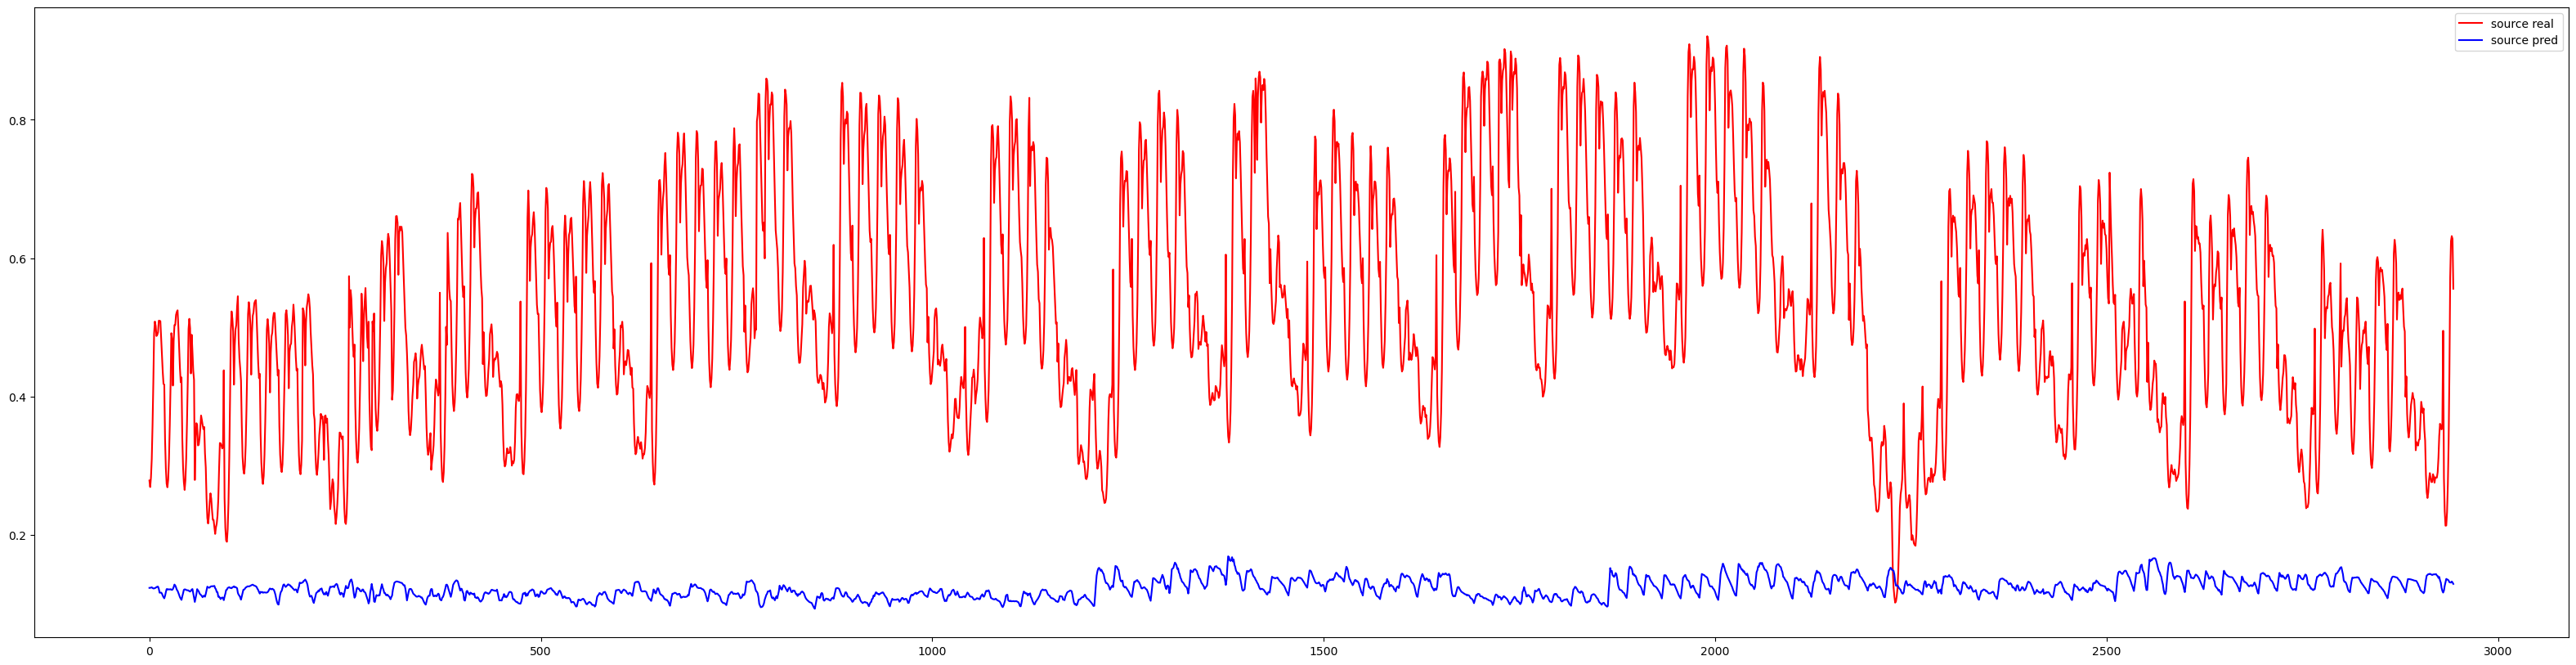

In [198]:
plt.figure(figsize=(40,10))
plt.plot(s_real, color='red', label='source real')
plt.plot(s_pred, color='blue', label='source pred')
plt.legend()
plt.show()

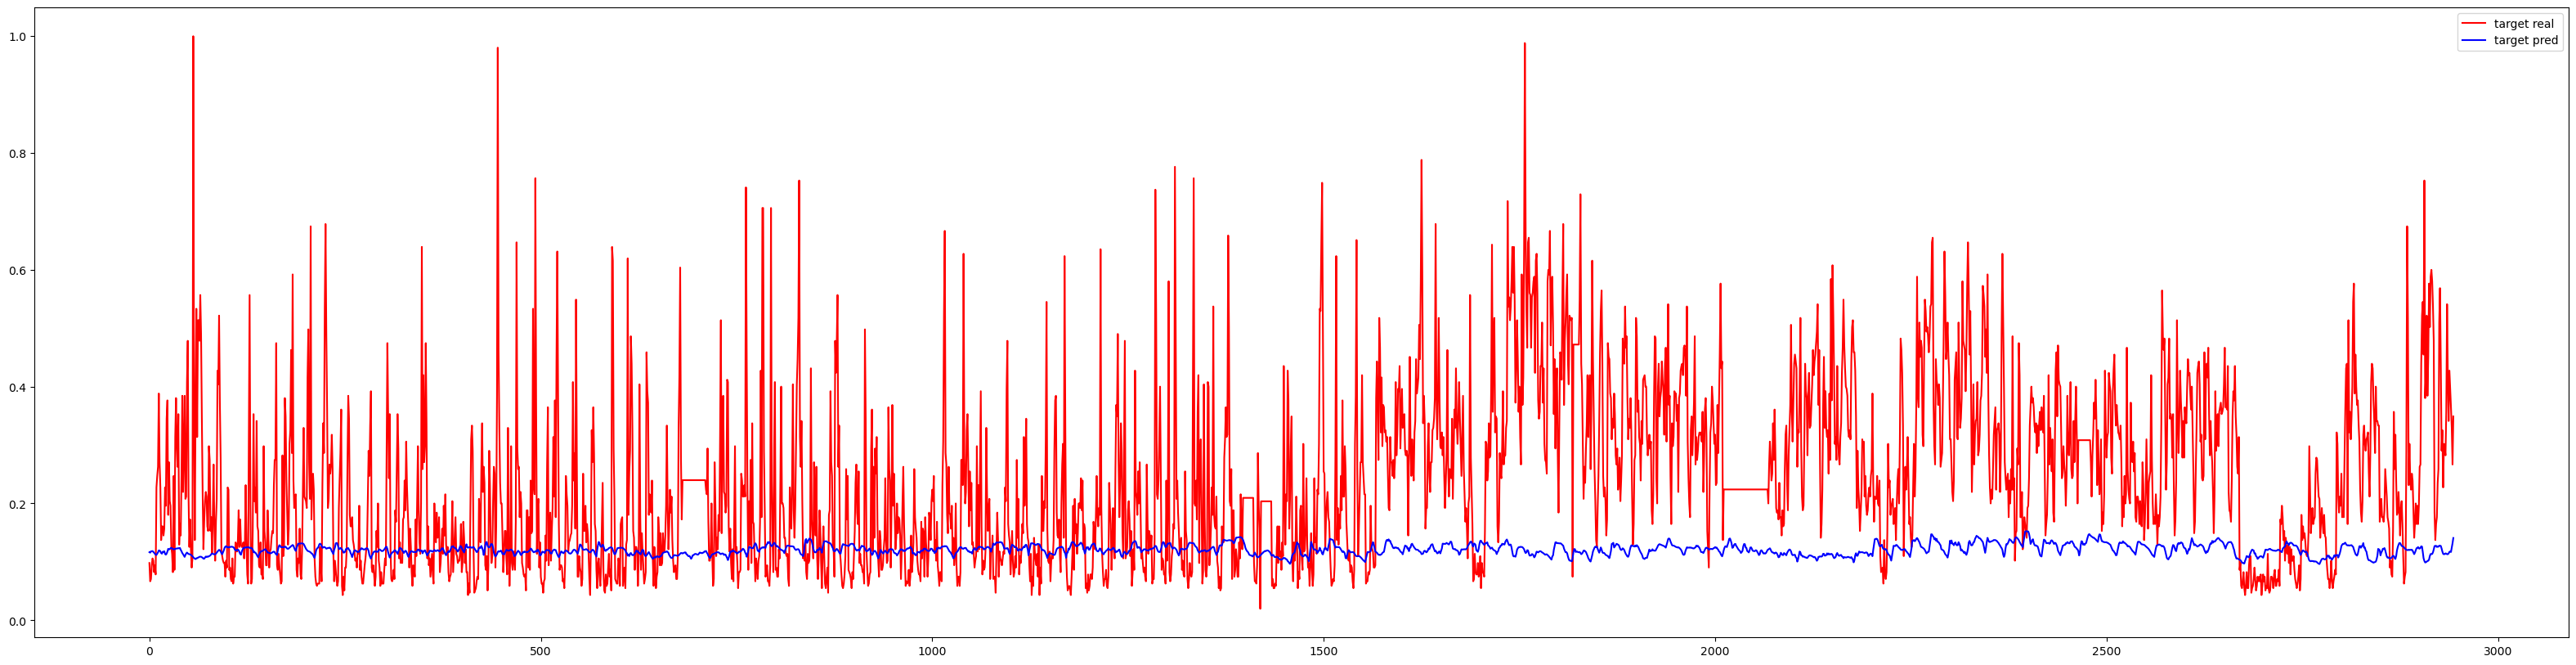

In [199]:
plt.figure(figsize=(40,10))
plt.plot(t_real, color='red', label='target real')
plt.plot(t_pred, color='blue', label='target pred')
plt.legend()
plt.show()

### Domain Embedding Space 시각화

In [200]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
source_tsne = DataLoader(nelec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

target_tsne = DataLoader(elec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

source_tsne2 = next(iter(source_tsne))
target_tsne2 = next(iter(target_tsne))

source_x_TNSE = source_tsne2[0].to(device)
source_y_TNSE = source_tsne2[1].to(device)

target_x_TNSE = target_tsne2[0].to(device)
target_y_TNSE = target_tsne2[1].to(device)

# 학습된 모델의 LSTM 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
source_vector = model.cnn(source_x_TNSE)
target_vector = model.cnn(target_x_TNSE)

In [201]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([source_vector.cpu().detach().numpy(), target_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

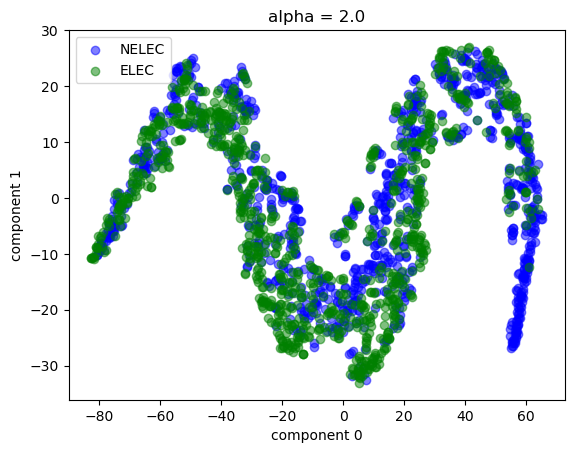

In [202]:
tsne_df_0 = tsne_df.loc[:1000]
tsne_df_1 = tsne_df.loc[1000:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='blue', label='NELEC', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='green', label='ELEC', alpha=0.5)

plt.title('alpha = '+ str(alpha))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()